# PROYECTO RECUPERACION DE IMAGENES

Para este proyecto de recuperacion de imagenes la idea original es tener una pagina web conecatada a un backend en donde se pueda subir una imagen como archivo, procesarla y retornar un conjunto de imagenes lo mas similares a la imagen subida

## 1. Importacion de librerias

Para que todas estas librerias esten instaladas se debe correr el comando: 

pip3 install -r requirements.txtx

In [16]:
import os
import numpy as np
import tensorflow as tf
import pickle
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from matplotlib import pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import precision_score, recall_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from collections import defaultdict
from sklearn.metrics import precision_score, recall_score, confusion_matrix

## 2. Carga de imagenes y del dataset

Se necesita  predimensionar las imagenes a 256x256 pixeles  

Cargar una imagen desde una ruta, redimensionarla a 256x256 píxeles y convertirla en un array NumPy.

In [2]:
def load_image(image_path):
    try:
        img = load_img(image_path, target_size=(256, 256))
        img_array = img_to_array(img)
        return img_array
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None

Cargar un conjunto de datos de imágenes desde un directorio, etiquetarlas y prepararlas para entrenamiento o evaluación.

In [3]:
def load_dataset(data_dir):
    images = []
    labels = []
    image_paths = []
    label_names = sorted(os.listdir(data_dir))
    label_map = {label_name: idx for idx, label_name in enumerate(label_names)}
    
    for label_name in label_names:
        label_dir = os.path.join(data_dir, label_name)
        if os.path.isdir(label_dir):
            for file_name in os.listdir(label_dir):
                if file_name.endswith(('.jpg', '.jpeg', '.png')):
                    image_path = os.path.join(label_dir, file_name)
                    img = load_image(image_path)
                    if img is not None:
                        images.append(img)
                        labels.append(label_map[label_name])
                        image_paths.append(image_path)
    
    print(f"Loaded {len(images)} images with {len(labels)} labels")
    images = np.array(images)
    labels = np.array(labels)
    return images, labels, label_map, image_paths

## 3. Division del corpus 

Se carga un conjunto de datos de imágenes desde el directorio `'101_ObjectCategories'` utilizando la función `load_dataset`, que devuelve arrays de imágenes, etiquetas, un diccionario de mapeo de etiquetas e información sobre las rutas de las imágenes. Luego, divide estos datos en conjuntos de entrenamiento y prueba, reservando el 80% para entrenamiento y el 20% para prueba. La división se realiza de manera estratificada para mantener la proporción original de las clases en ambos conjuntos, garantizando que el modelo se entrene y se evalúe de manera representativa.

In [4]:
data_dir = '101_ObjectCategories'
images, labels, label_map, image_paths = load_dataset(data_dir)

train_images, test_images, train_labels, test_labels, train_paths, test_paths = train_test_split(
    images, labels, image_paths, train_size=0.8, stratify=labels)

Loaded 8677 images with 8677 labels


In [5]:
print(f"Training set: {len(train_images)} images, Test set: {len(test_images)} images")

Training set: 6941 images, Test set: 1736 images


## 4. Carga del Modelo VGG16 con Pesos Locales

Carga el modelo VGG16 utilizando pesos preentrenados desde un archivo local (`'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'`), omitiendo la capa densa final del modelo (`include_top=False`).

In [6]:
# Load VGG16 model with local weights
local_weights_file = 'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model = VGG16(weights=local_weights_file, include_top=False, input_shape=(224, 224, 3))
model = tf.keras.models.Model(inputs=base_model.input, outputs=base_model.layers[-1].output)

## 5. Preprocesamiento y Extracción de Características de Imágenes

Estas funciones están diseñadas para preprocesar una imagen y extraer sus características utilizando un modelo VGG16.

In [7]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.vgg16.preprocess_input(img_array)
    return img_array

def extract_features(model, image_path):
    img_array = preprocess_image(image_path)
    features = model.predict(img_array)
    return features.flatten()

### Diferencia fundamental de codigo antiguo (codigo con falla de indices)
 
En el primer código, las características se almacenan en arrays de NumPy y deben ser cuidadosamente indexadas y administradas para asegurarse de que las búsquedas sean precisas. Si hay algún problema en la carga o almacenamiento de estos arrays, las búsquedas pueden fallar.

En el segundo código, cada imagen se procesa de manera más aislada y las características se almacenan en un diccionario, lo que puede simplificar la búsqueda de características específicas, ya que se utilizan claves únicas (rutas de archivo) para acceder a las características.

Se procede a utilizar como codigo final al caragar las imagenes de forma mas aislada y almacenarlas en un diccionario

## 6. Indexación de Características de Imágenes y Almacenamiento

Este código crea un diccionario `index` para almacenar las características y categorías de cada imagen en el conjunto de datos. Recorre cada imagen en los conjuntos de entrenamiento y prueba, extrayendo sus características mediante la función `extract_features` y asociando estas características con su etiqueta correspondiente. Cada entrada en el diccionario tiene la ruta de la imagen como clave y una tupla con las características y la etiqueta como valor. Luego, guarda el diccionario en un archivo llamado `'index.pkl'` utilizando `pickle` para su almacenamiento persistente. Finalmente, imprime el número total de imágenes indexadas.

In [17]:
# Dictionary to store the characteristics and categories of each image
index = {}

# Iterate through each image in the training and test sets
for image_path, label in zip(train_paths + test_paths, train_labels.tolist() + test_labels.tolist()):
    features = extract_features(model, image_path)
    index[image_path] = (features, label)

# Save the feature dictionary to a file using pickle
with open('index.pkl', 'wb') as f:
    pickle.dump(index, f)

print(f'Indexed {len(index)} images.')

1/1 [==============================] - 0s 259ms/step
Indexado 8677 imágenes.


## 7.Carga y Extracción de Datos del Diccionario de Características

Se carga un diccionario de características previamente almacenado en el archivo `'index.pkl'` usando `pickle`. Una vez cargado, extrae las rutas de las imágenes, las características asociadas y las etiquetas del diccionario. Las rutas de las imágenes se almacenan en una lista, mientras que las características se convierten en un array NumPy y las etiquetas se recopilan en una lista. Esto prepara los datos para su uso en análisis o entrenamiento de modelos.

In [8]:
# Load the feature dictionary from the index.pkl file
with open('index.pkl', 'rb') as f:
    index = pickle.load(f)

# Extract features and labels from the dictionary
image_paths = list(index.keys())
features = np.array([index[path][0] for path in image_paths])
labels = [index[path][1] for path in image_paths]

## 8. Búsqueda de Imágenes Similares y Visualización

Este código configura un modelo de vecinos más cercanos (`NearestNeighbors`) para encontrar imágenes similares basadas en características extraídas. Primero, se inicializa el modelo `NearestNeighbors` con 5 vecinos más cercanos y se ajusta con las características extraídas de las imágenes. La función `find_similar_images` toma la ruta de una imagen de consulta, extrae sus características y encuentra las imágenes más similares utilizando el modelo. Devuelve una lista de imágenes similares con sus distancias a la imagen de consulta. La función `show_images` visualiza la imagen de consulta junto con las imágenes similares, mostrando cada una con su distancia correspondiente. Utiliza `matplotlib` para mostrar las imágenes en un solo gráfico, con la imagen de consulta en primer lugar y las imágenes similares a continuación.

In [9]:
nbrs = NearestNeighbors(n_neighbors=5, algorithm='auto').fit(features)

def find_similar_images(query_image_path):
    query_features = extract_features(model, query_image_path)
    distances, indices = nbrs.kneighbors([query_features])
    
    similar_images = [(image_paths[idx], distances[0][i]) for i, idx in enumerate(indices[0])]
    return similar_images

def show_images(query_image_path, similar_images):
    fig, axes = plt.subplots(1, 6, figsize=(20, 5))
    query_img = load_img(query_image_path, target_size=(224, 224))
    axes[0].imshow(query_img)
    axes[0].set_title('Query Image')
    axes[0].axis('off')

    for i, (img_path, dist) in enumerate(similar_images):
        similar_img = load_img(img_path, target_size=(224, 224))
        axes[i + 1].imshow(similar_img)
        axes[i + 1].set_title(f'Similar {i+1}\nDist: {dist:.2f}')
        axes[i + 1].axis('off')

    plt.show()

## 9. Consulta de una query

In [20]:
query_image_path = '101_ObjectCategories/anchor/image_0002.jpg'
similar_images = find_similar_images(query_image_path)

1/1 [==============================] - 0s 150ms/step


Top 5 imágenes similares a 101_ObjectCategories/anchor/image_0002.jpg:
101_ObjectCategories/anchor/image_0002.jpg con una distancia de 0.00
101_ObjectCategories/airplanes/image_0554.jpg con una distancia de 1826.39
101_ObjectCategories/pyramid/image_0051.jpg con una distancia de 1831.22
101_ObjectCategories/bonsai/image_0079.jpg con una distancia de 1836.55
101_ObjectCategories/Leopards/image_0163.jpg con una distancia de 1842.46


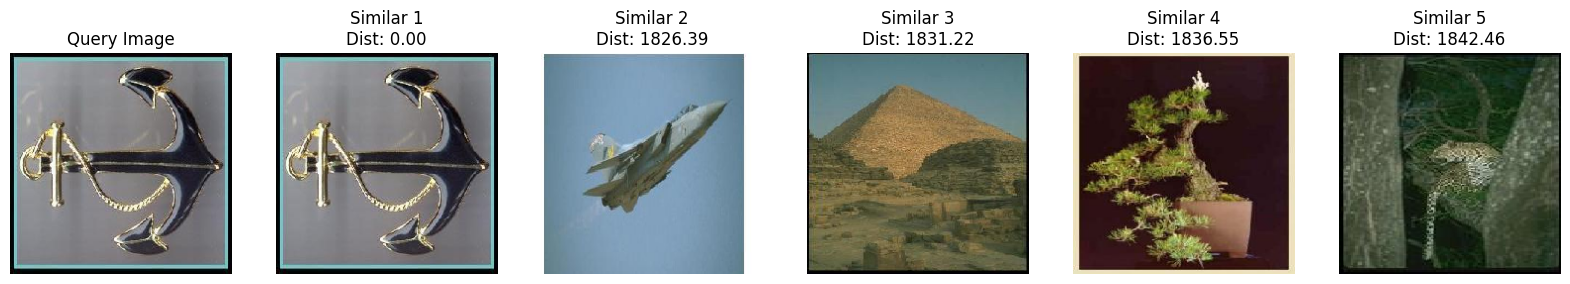

In [21]:
print(f"Top 5 imágenes similares a {query_image_path}:")
for img_path, dist in similar_images:
    print(f"{img_path} con una distancia de {dist:.2f}")

show_images(query_image_path, similar_images)

## 9. Evaluacion de precision y recall

In [17]:
# Ground truth

ground_truth = defaultdict(list)

for category in os.listdir(data_dir):
    print(category)
    for image_path in os.listdir(os.path.join(data_dir, category)):
        image_path = os.path.join(data_dir, category, image_path)
        ground_truth[category].append(image_path)


gerenuk
hawksbill
headphone
ant
butterfly
lamp
strawberry
water_lilly
chandelier
dragonfly
crab
pagoda
dollar_bill
emu
inline_skate
platypus
dalmatian
cup
airplanes
joshua_tree
cougar_body
grand_piano
trilobite
brontosaurus
wild_cat
pigeon
dolphin
soccer_ball
wrench
scorpion
flamingo_head
nautilus
accordion
cougar_face
pyramid
camera
barrel
schooner
cellphone
panda
revolver
lobster
menorah
lotus
stapler
crocodile
chair
helicopter
minaret
starfish
ceiling_fan
ketch
mayfly
wheelchair
bass
yin_yang
crocodile_head
saxophone
beaver
mandolin
bonsai
Leopards
car_side
ibis
electric_guitar
kangaroo
stegosaurus
ferry
snoopy
umbrella
rhino
okapi
watch
brain
gramophone
scissors
rooster
cannon
binocular
anchor
octopus
buddha
laptop
windsor_chair
hedgehog
pizza
euphonium
stop_sign
Motorbikes
sea_horse
flamingo
ewer
garfield
crayfish
Faces_easy
Faces
sunflower
llama
elephant
tick
metronome


In [18]:
ground_truth

defaultdict(list,
            {'gerenuk': ['101_ObjectCategories/gerenuk/image_0032.jpg',
              '101_ObjectCategories/gerenuk/image_0026.jpg',
              '101_ObjectCategories/gerenuk/image_0027.jpg',
              '101_ObjectCategories/gerenuk/image_0033.jpg',
              '101_ObjectCategories/gerenuk/image_0019.jpg',
              '101_ObjectCategories/gerenuk/image_0025.jpg',
              '101_ObjectCategories/gerenuk/image_0031.jpg',
              '101_ObjectCategories/gerenuk/image_0030.jpg',
              '101_ObjectCategories/gerenuk/image_0024.jpg',
              '101_ObjectCategories/gerenuk/image_0018.jpg',
              '101_ObjectCategories/gerenuk/image_0020.jpg',
              '101_ObjectCategories/gerenuk/image_0034.jpg',
              '101_ObjectCategories/gerenuk/image_0008.jpg',
              '101_ObjectCategories/gerenuk/image_0009.jpg',
              '101_ObjectCategories/gerenuk/image_0021.jpg',
              '101_ObjectCategories/gerenuk/image_0023.j

In [23]:
def evaluate_model_by_category(nbrs, image_paths, ground_truth, n_neighbors=5):
    precisions = []
    recalls = []
    conf_matrices = []

    for category, true_images in ground_truth.items():
        true_labels = []
        pred_labels = []

        for true_image in true_images:
            # Obtener imágenes similares utilizando el modelo
            similar_images = find_similar_images(true_image)

            # Crear etiquetas verdaderas (1 si pertenece a la misma categoría, 0 si no)
            category_true_labels = [1 if os.path.dirname(img_path) == os.path.dirname(true_image) else 0 
                                    for img_path, dist in similar_images]
            # Etiquetas predichas siempre se consideran como 1 porque el modelo asume que todos los resultados son positivos
            category_pred_labels = [1] * len(category_true_labels)

            # Almacenar los resultados por categoría
            true_labels.extend(category_true_labels)
            pred_labels.extend(category_pred_labels)

        # Calcular precisión, recall y matriz de confusión para la categoría actual
        precision = precision_score(true_labels, pred_labels, zero_division=0)
        recall = recall_score(true_labels, pred_labels, zero_division=0)
        conf_matrix = confusion_matrix(true_labels, pred_labels)

        precisions.append(precision)
        recalls.append(recall)
        conf_matrices.append(conf_matrix)

    # Promediar los resultados de todas las categorías
    avg_precision = sum(precisions) / len(precisions)
    avg_recall = sum(recalls) / len(recalls)
    avg_conf_matrix = sum(conf_matrices)  # Sumar todas las matrices de confusión

    return avg_precision, avg_recall, avg_conf_matrix

# Ejemplo de uso
avg_precision, avg_recall, avg_conf_matrix = evaluate_model_by_category(nbrs, image_paths, ground_truth)

1/1 [==============================] - 0s 88ms/step


In [25]:
print(f"Precisión promedio del modelo: {avg_precision:.2f}")
print(f"Recall promedio del modelo: {avg_recall:.2f}")
print("Matriz de confusión promedio:")
print(avg_conf_matrix)

Precisión promedio del modelo: 0.56
Recall promedio del modelo: 1.00
Matriz de confusión promedio:
[[  615 13690]
 [  615 30310]]
